In [1]:
import numpy as np
import pandas as pd
import requests
from epiweeks import Week, Year
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
PATH = 'https://raw.githubusercontent.com/KITmetricslab/nowcasting-data/main/'
# DISEASE = 'Seasonal_Influenza' 
# DISEASE = 'RSV_Infection'
DISEASE = 'Pneumococcal_Disease'    

TYPE = 'age'

MAX_DELAY = 10

In [3]:
LOCATION_CODES = {'Deutschland': 'DE',
                  'Schleswig-Holstein': 'DE-SH',
                  'Hamburg': 'DE-HH',
                  'Niedersachsen': 'DE-NI',
                  'Bremen': 'DE-HB',
                  'Nordrhein-Westfalen': 'DE-NW',
                  'Hessen': 'DE-HE',
                  'Rheinland-Pfalz': 'DE-RP',
                  'Baden-Württemberg': 'DE-BW',
                  'Bayern': 'DE-BY',
                  'Saarland': 'DE-SL',
                  'Berlin': 'DE-BE',
                  'Brandenburg': 'DE-BB',
                  'Mecklenburg-Vorpommern': 'DE-MV',
                  'Sachsen': 'DE-SN',
                  'Sachsen-Anhalt': 'DE-ST',
                  'Thüringen': 'DE-TH'}

In [4]:
def ages_by_group(age_group):
    if age_group == '80+':
        return {'A80.': '80+'}
    limits = age_group.split("-")
    keys = [f"A{a:02d}..{a:02d}" for a in range(int(limits[0]), int(limits[1]) + 1)]
    return dict.fromkeys(keys, age_group)

AGE_GROUPS = ["00-04", "05-14", "15-34", "35-59", "60-79", "80+"]

AGE_DICT = dict()
for age_group in AGE_GROUPS:
    AGE_DICT.update(ages_by_group(age_group))

In [5]:
def process_state_file(df):
    # add iso date (end date of the corresponding week)
    df['date'] = df.apply(lambda x: Week(x.year, x.week, system = 'iso').enddate(), axis = 1)
    
    df = df.rename(columns = {'stratum' : 'location'})
    
    # fix state names and replace with abbreviations
    df.location = df.location.replace({'Ã.': 'ü', '\.': '-'}, regex = True)
    df.location = df.location.replace(LOCATION_CODES)
    
    # fill in age_group
    df['age_group'] = '00+'
    
    df = df[['date', 'year', 'week', 'location', 'age_group', 'value']]
    df = df.sort_values(['location', 'age_group', 'date'], ignore_index = True)

    return df

In [6]:
def process_age_file(df):
    # add iso date (end date of the corresponding iso week)
    df['date'] = df.apply(lambda x: Week(x.year, x.week, system = 'iso').enddate(), axis = 1)
    
    df = df.rename(columns = {'stratum' : 'age_group'})
    
    # drop entries with unknown age group
    df = df[df.age_group != "Unbekannt"]
    
    # summarize age groups (from yearly resolution to specified groups)
    df.age_group = df.age_group.replace(AGE_DICT)
    df = df.groupby(['date', 'year', 'week', 'age_group'], as_index = False)['value'].sum()
    
    # compute sum for age group 00+
    df_all = df.groupby(['date', 'year', 'week'], as_index = False)['value'].sum()
    df_all['age_group'] = '00+'
    
    df = pd.concat([df, df_all])
    
    # fill in location
    df['location'] = 'DE'
    
    df = df[['date', 'year', 'week', 'location', 'age_group', 'value']]
    df = df.sort_values(['location', 'age_group', 'date'], ignore_index = True)

    return df

In [7]:
def load_processed_file(path):
    try:
        df = pd.read_csv(path)

        if 'states' in path:
            df = process_state_file(df)
        elif 'age' in path:
            df = process_age_file(df)
        
        return df
        
    except:
        return None

In [8]:
def load_data(disease, date):
    try:
        df1 = pd.read_csv(f"{PATH}/{disease}/{disease}-states-{date}.csv")
        df2 = pd.read_csv(f"{PATH}/{disease}/{disease}-age-{date}.csv")

        df1 = process_state_file(df1)
        df2 = process_age_file(df2)

        df = pd.concat([df1, df2])
        df = df.sort_values(['location', 'age_group', 'date'], ignore_index = True)
        
        return df
        
    except:
        return None 

In [9]:
def add_iso_dates(df):
    '''
    Adds iso_week, iso_year and iso_date (end date of the week) to dataframe.
    '''
    df['iso_week'] = df.date.apply(lambda x: Week.fromdate(x, system = 'iso').week)
    df['iso_year'] = df.date.apply(lambda x: Week.fromdate(x, system = 'iso').year)
    df['iso_date'] = df.apply(lambda x: Week(x.iso_year, x.iso_week, system = 'iso').enddate(), axis = 1)
    
    return(df)

In [10]:
def add_iso_dates(df):
    '''
    Adds iso_week, iso_year and iso_date (end date of the week) to dataframe.
    '''
    df['iso_week'] = df.date.apply(lambda x: Week.fromdate(x, system = 'iso').week)
    df['iso_year'] = df.date.apply(lambda x: Week.fromdate(x, system = 'iso').year)
    df['iso_date'] = df.apply(lambda x: Week(x.iso_year, x.iso_week, system = 'iso'), axis = 1)
    
    return(df)

In [11]:
def list_all_files(disease, stratum):
    # download all files from repo
    url = 'https://api.github.com/repos/KITmetricslab/nowcasting-data/git/trees/main?recursive=1'
    r = requests.get(url)
    res = r.json()
    
    # filter relevant files
    files = sorted([file['path'] for file in res['tree'] if (file['path'].startswith(disease) and 
                                                             file['path'].endswith('.csv') and
                                                             stratum in file['path'])])
    
    # create dataframe so we can easily select files by date
    df_files = pd.DataFrame({'filename':files})

    # extract date from filename
    df_files['date'] = df_files.filename.str[-14:-4]
    df_files.date = pd.to_datetime(df_files.date)
    
    df_files = add_iso_dates(df_files)
    
    # only keep latest file per week
    df_files = df_files.sort_values('date').groupby(['iso_year', 'iso_week']).tail(1).reset_index(drop = True)
    
    return df_files

In [12]:
df_files = list_all_files(DISEASE, TYPE)

In [13]:
df_files.head()

,filename,date,iso_week,iso_year,iso_date
0,Pneumococcal_Disease/Pneumococcal_Disease-age-...,2021-10-28,43,2021,2021W43
1,Pneumococcal_Disease/Pneumococcal_Disease-age-...,2021-11-07,44,2021,2021W44
2,Pneumococcal_Disease/Pneumococcal_Disease-age-...,2021-11-14,45,2021,2021W45
3,Pneumococcal_Disease/Pneumococcal_Disease-age-...,2021-11-21,46,2021,2021W46
4,Pneumococcal_Disease/Pneumococcal_Disease-age-...,2021-11-28,47,2021,2021W47


In [14]:
date_dict = dict(zip(df_files.iso_date, df_files.date))

In [15]:
max_date = df_files.iso_date.max().enddate()
min_date = df_files.iso_date.min().enddate()

In [16]:
dates = pd.date_range(min_date, max_date, freq = "1W")
dates = [Week.fromdate(d, system = 'iso') for d in dates]

In [17]:
dfs = []
for date in dates:
    
    if date in date_dict.keys():
        df_temp = load_data(disease = DISEASE, date = date_dict[date].date())
    else:
        df_temp = None
    
    # select relevant rows if df_temp is not None
    if df_temp is not None:
        df_temp = df_temp[(df_temp.date == date_dict[date].date())]
    
    # add rows (with valid year, week, date but no value) if date is missing in file or file couldn't be loaded
    if df_temp is None or len(df_temp) == 0:
        try:
            df_temp = dfs[-1].copy()
            df_temp.year = date.year
            df_temp.week = date.week
            df_temp.date = date.enddate()
            df_temp.value = np.nan
        except:
            print(f"Warning: No data for {date.enddate()}.")
    dfs.append(df_temp)
    

df = pd.concat(dfs)

# if initial report is missing replace with zero
df.value.fillna(0, inplace = True)

df.rename(columns = {'value': 'value_0w'}, inplace = True)

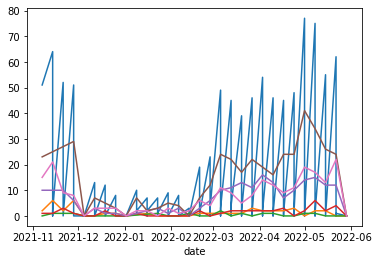

In [18]:
df.set_index('date').groupby('age_group')['value_0w'].plot();

In [19]:
def safe_loading(date):
    return
    # TODO

In [20]:
for delay in tqdm(range(1, MAX_DELAY + 1), total = MAX_DELAY):
    dfs_delayed = []
    for date in dates:
        date_delayed = date + delay 
        if date_delayed <= max(dates):
            if date_delayed in date_dict.keys():
                df_temp = load_data(disease = DISEASE, date = date_dict[date_delayed].date())
            else:
                df_temp = None
                
            # select relevant rows if df_temp is not None
            if df_temp is not None:
                df_temp = df_temp[(df_temp.date == date.enddate())]
            
            # add rows (with valid year, week, date but no value) if date is missing in file or file couldn't be loaded
            if df_temp is None or len(df_temp) == 0:
                try:
                    df_temp = dfs[-1].copy()
                    df_temp.year = date.year
                    df_temp.week = date.week
                    df_temp.date = date.enddate()
                    df_temp.value = np.nan
                except:
                    print(f"Warning: No data for {date.enddate()}.")
            dfs_delayed.append(df_temp)
            
    df_delayed = pd.concat(dfs_delayed)
    # we flag missing values to fill later on (not all should be filled to preserve reporting triangle shape)
    df_delayed.value.fillna('to_fill', inplace = True)  
    df_delayed.rename(columns = {'value': f'value_{delay}w'}, inplace = True)
    df = df.merge(df_delayed, how = 'left')

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
# use latest file to compute column for remaining correction beyond the specified largest delay
df_latest = load_data(DISEASE, df_files.date.iloc[-1].date())

df_latest.value = df_latest.value.fillna('to_fill')

df_latest = df_latest.rename(columns = {'value': f'value_>{MAX_DELAY}w'})

In [22]:
df = df.merge(df_latest, how = 'left')

In [23]:
df.tail()

,date,year,week,location,age_group,value_0w,value_1w,value_2w,value_3w,value_4w,value_5w,value_6w,value_7w,value_8w,value_9w,value_10w,value_>10w
599,2022-05-29,2022,21,DE-SH,00+,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
600,2022-05-29,2022,21,DE-SL,00+,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_fill
601,2022-05-29,2022,21,DE-SN,00+,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,to_fill
602,2022-05-29,2022,21,DE-ST,00+,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
603,2022-05-29,2022,21,DE-TH,00+,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [24]:
# we want to keep the triangle shape and avoid filling the corresponding entries
df = df.fillna('not_observed')

# we use forward filling to fill missing values in between
df = df.replace({'to_fill' : np.nan})
df = df.fillna(method = "ffill", axis = 1)

df = df.replace({'not_observed' : np.nan})

In [25]:
# compute differences
df.iloc[:, 6:] = df.iloc[:, 5:].diff(axis=1).iloc[:, 1:]

In [26]:
value_cols = [c for c in df.columns if 'value' in c]
for col in value_cols:
    df[col] = df[col].astype('Int64')

df = df[['location', 'age_group', 'year', 'week', 'date'] + value_cols]

df = df.sort_values(['location', 'age_group', 'date'], ignore_index = True)

In [27]:
df.to_csv(f'../data/truth/truth_{DISEASE.lower()}.csv', index = False)